In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scarlet
import pickle

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord

#plt.rcParams['font.size'] = 15
#plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

### Make one figure containing all useful information

In [2]:
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/tigress/jiaxuanl/Data')

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [3]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')

In [5]:
lsbg_cat[:5]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,objectid,Seq,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,arcsec,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,float64,bytes54,float64,bool,bool
225.3020883,1.0550868,26.224,17.616,82.68,0.328,20.0629,18.5655,18.0075,14.22708,22.39902,27.266820128426676,26.55830937698006,1.1643505268070824,1.2578408501384883,0.9366706388175572,0.12434132134058919,0.08811196015814717,0.06288217147907928,9621,"3,6",-1,42352,42352,0,1.5,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_0,1.5,True .. True,True .. True
181.0873682,-1.5183761,53.428,42.355,-68.95,0.207,18.3062,17.8858,17.8293,14.193396,15.345876000000002,25.70770227989263,25.478894362201697,1.1545371610349655,-0.035240274241365416,0.055489525447205645,0.06421546096516757,0.045504986412372064,0.032475186723801105,9106,"6,8",-1,32953,32953,1,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_1,1.0,True .. True,True .. True
190.2022409,0.4494237,62.347,32.252,-20.65,0.483,17.1944,16.5843,16.3879,9.581712,12.665184,23.52783882994563,23.21341914966895,1.0213855491325439,0.49571079112197586,0.35251549764511914,0.051770908825189185,0.036686406470308824,0.02618169994716496,9597,"1,2",-1,62597,62597,2,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_2,1.0,True .. True,True .. True
333.6455774,1.6049543,15.95,5.242,13.16,0.671,21.8598,20.8905,20.4607,9.557184,16.077432,28.242039019042227,28.213308439789063,1.3677127872658572,0.14076629586789444,0.19316048229509267,0.10790229377916456,0.07646277607425488,0.054568589647056624,9936,"2,1",-1,56240,56240,3,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_3,1.0,True .. True,True .. True
139.8679525,3.7603522,23.143,15.864,-11.75,0.315,20.765,19.1098,18.8354,8.567496,16.728096,26.58988343975888,26.844953931059088,1.0778980753223444,0.6939786196199077,0.47221906112762835,0.14854275517449633,0.10526181630212529,0.07512137479440194,10048,"4,4",-1,60593,60593,4,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_4,1.0,True .. True,True .. True


In [6]:
lsbg = lsbg_cat[0]
channels = 'grizy'

cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

In [8]:
# Reconstructure data
from kuaizi.utils import padding_PSF
from kuaizi.mock import Data

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = channels
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
data = Data(images=images, weights=weights, wcs=w, psfs=psfs, channels=channels)

### Run scarlet modeling

In [4]:
from kuaizi.fitting import fitting_wavelet_obs_tigress, _fitting_wavelet
import os

In [5]:
# scarlet_flag
# 0: not processed
# 1: no bug
# -1: problematic
# lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [24]:
fail_logger = kz.utils.set_logger(logger_name='candy_fail', file_name='candy_fail', level='ERROR')
global_logger = kz.utils.set_logger(logger_name='candy_sample', file_name='candy_log', level='INFO')

In [96]:
index = 157
blend = fitting_wavelet_obs_tigress(
    {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}, 
    lsbg_cat[index],
    name='Seq',
    channels='griz',
    starlet_thresh=0.5,
    prefix='candy',
    show_figure=False, 
    global_logger=global_logger, 
    fail_logger=fail_logger)

# if blend: # if succeeded
#     lsbg_cat[index]['scarlet_flag_0.5'] = 1
# else:
#     lsbg_cat[index]['scarlet_flag_0.5'] = -1

### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_157`
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    2 stars from Gaia are masked!
    Detected 89 objects
    2 stars from Gaia are masked!
    Detected 125 objects
    Detected 45 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.30, starlet_thresh = 0.50 (contam_ratio = 0.01).
    Optimizaiton: Succeed for e_rel = 1e-04 with 17 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-06 with 53 iterations! Try higher accuracy!
  - After 53 iterations, logL = 1585282.95
    Elapsed time for fitting: 27.36 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/candy-157-trained-model-wavelet.df


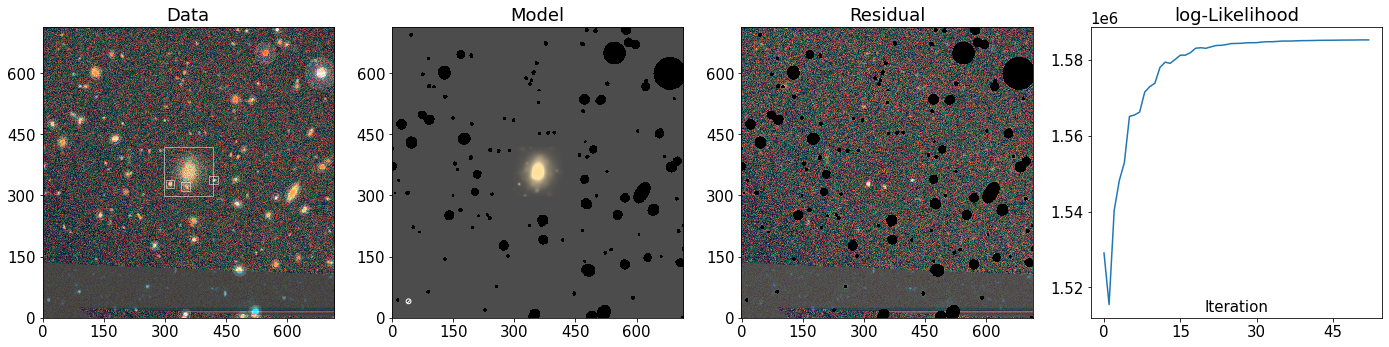

In [97]:
fig = kz.display.display_scarlet_results_tigress(
        blend,
        show_ind=[0],
        #zoomin_size=120,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

#plt.savefig('/tigress/jiaxuanl/public_html/candy/candy-2-zoomin.png', dpi=55, bbox_inches='tight')

## Multiprocessing

In [61]:
lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)
global_logger = kz.utils.set_logger(logger_name='candy_sample', file_name='candy_log', level='ERROR')

In [60]:
from multiprocessing import Pool, Manager
from functools import partial

In [63]:
def multiprocess_fitting(index):
    #if not os.path.isfile(f'./Models/LSBG-{lsbg_cat[index]["Seq"]:04d}-trained-model-wavelet.df'): 
    blend = fitting_wavelet_obs_tigress(
        {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}, 
        lsbg_cat[index],
        name='Seq',
        channels='griz',
        starlet_thresh=0.5,
        prefix='candy',
        show_figure=False, 
        global_logger=global_logger)
    if blend: # if succeeded
        lsbg_cat[index]['scarlet_flag_0.5'] = 1
    else:
        lsbg_cat[index]['scarlet_flag_0.5'] = -1

print('Number of processor to use:')
n_jobs = 6
manager = Manager()
pool = Pool(n_jobs)

#measurement_cat = manager.dict()
iterable = np.arange(0, 21, 1) # np.random.randint(0, len(lsbg_cat), 50)

#func = partial(fitting_single_comp, s18a)
pool.map(multiprocess_fitting, iterable)
pool.close()
pool.join()

Number of processor to use:
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_2`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_0`### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_1`### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_4`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_3`
### Running scarlet wavelet modeling for `/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_5`


  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
  - Detect sources and make mask  - Detect sources and make mask  - Detect sources and make mask  - Detect sources and make mask



    Query GAIA stars...    Query GAIA stars...    Query GAIA stars...    Query GAIA stars...



    Taking Gaia catalogs stored in `Tigress`    Taking Gaia catalo

## Generate html

In [4]:
import os, re
import numpy as np

In [5]:
## get the indices of successful modeling
figlist = os.listdir('/tigress/jiaxuanl/Data/HSC/LSBG/Figure/')
figlist = [item for item in figlist if '-zoomin-wavelet.png' in item] # only select png
ind_array = np.asarray([re.findall('-\d+-', item)[0].strip('-') for item in figlist], dtype=int)
ind_array.sort()
fail_array = np.setdiff1d(np.arange(0, len(lsbg_cat)), ind_array)
print(f'Failed {len(fail_array)} galaxies (based on checking figures):', fail_array)

## Check log files, find out error items
with open('/tigress/jiaxuanl/Data/HSC/LSBG/candy_fail_0_100', 'r') as f:
    log = f.read()
    f.close()    
with open('/tigress/jiaxuanl/Data/HSC/LSBG/candy_fail_100_200', 'r') as f:
    log = f.read()
    f.close()
with open('/tigress/jiaxuanl/Data/HSC/LSBG/candy_fail_200_300', 'r') as f:
    log = f.read()
    f.close()
with open('/tigress/jiaxuanl/Data/HSC/LSBG/candy_fail_complement', 'r') as f:
    log = f.read()
    f.close()

loglist = log.split('\n')
loglist = [item for item in loglist if len(item) > 0]
loglist = [item for item in loglist if 'ERROR' in item] # find out error items
fail_log_array = np.unique(np.array([re.findall('candy_\d+', item)[0].strip('candy_') for item in loglist], dtype=int))
print(f'Failed {len(fail_log_array)} galaxies (based on checking log files):', fail_log_array)

Failed 5 galaxies (based on checking figures): [110 165 181 182 196]
Failed 5 galaxies (based on checking log files): [110 165 181 182 196]


In [6]:
os.system('cp /tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy-*-zoomin-*.png /tigress/jiaxuanl/public_html/candy/scarlet_zoomin')

0

In [1]:
# webpage at `/tigress/jiaxuanl/public_html/candy/scarlet_zoomin/`
# http://tigress-web.princeton.edu/~jiaxuanl/candy/scarlet_zoomin/page1.html

In [16]:
## Count figures in public_html/candy/scarlet_zoomin
# figlist = os.listdir('/tigress/jiaxuanl/public_html/candy/scarlet_zoomin/')
# figlist = [item for item in figlist if '-zoomin-wavelet.png' in item] # only select png
# index_list = [int(re.findall('\d+', item)[0]) for item in figlist]
# index_list = np.sort(index_list)
print(f'You have {len(ind_array)} galaxies to be displayed')

row_num = 10
page_num = int(np.ceil(len(lsbg_cat) // (row_num)))
print('Total pages:', page_num)

You have 295 galaxies to be displayed
Total pages: 30


In [19]:
for k in range(page_num):
    f = open(f'/tigress/jiaxuanl/public_html/candy/scarlet_zoomin/page{k + 1}.html', 'w')
    f.write('<!DOCTYPE html> \n<html><head> \n<link rel="stylesheet" type="text/css" href="../../mystyle.css"> \n</head><body> \n\n')
    f.write('<script src="//code.jquery.com/jquery-1.11.3.min.js"></script>\n')
    f.write('<script type="text/javascript" src="../../myjs.js"></script> \n')
    f.write('<title>Scarlet Modeling Candy Sample</title> \n')
    f.write('\n\n</head><body> \n\n')
    
    f.write('<div class="header"> \n<h1>Candy Sample: "griz" bands, starlet_thresh = 0.5</h1> \n</div> \n\n')
    f.write('<div class="navigator"> \n')
    
    # Write navigator
    f.write('   <a href="page1.html" class="first">First</a> ')
    if k == 0:
        f.write('   <a href="#" class="previous">&laquo; Previous</a> \n')
    else:
        f.write(f'   <a href="page{k}.html" class="previous">&laquo; Previous</a> \n')
    
    f.write(f'   <a href="#" class="current">Page {k + 1}</a> \n')
    
    if k == page_num - 1:
        f.write('   <a href="#" class="next">Next &raquo;</a> \n')
    else:
        f.write(f'   <a href="page{k + 2}.html" class="next">Next &raquo;</a> \n')
    f.write(f'   <a href="page{page_num}.html" class="last">Last</a>')
    
    # Write search box
    f.write('<div class="searchbox"> \n<form id="jumper" method="get" onsubmit="return jumptopage_scarlet()">\n')
    f.write('   <label class="text_index">Index: </label>\n   <input type="text" id="galind" placeholder="123" name="GalaxyIndex">\n')
    f.write('   <button type="submit" class="buttonjump" value="submit">Jump</button>\n   <button type="reset" class="buttonreset">Reset</button>\n ')
    f.write('</form>\n </div>\n')
    
    f.write('</div> \n\n')
    
    for i in range(row_num):
        ind = row_num * k + i
        
        if ind in fail_array:
            f.write(f'<div class="row fail" id="candy{ind}"> \n')
            f.write(f'   <figure><h1>Failed!</h1><figcaption>Candy {ind}</figcaption> </figure>\n')
        elif ind in ind_array:
            f.write(f'<div class="row" id="candy{ind}"> \n')
            f.write(f'   <figure><img src="candy-{ind}-zoomin-wavelet.png" style="width:100%"> <figcaption>Candy {ind}</figcaption> </figure>\n')
        
        f.write(f'</div> \n\n')
    
    #         if ind >= len(index_list):
#             break

    f.write('</body></html> \n')
    f.close()

In [11]:
for i in range(30):
#     print('<div class="row">')
#     print(f'      <figure> <img src="zoomin/candy_{i}_zoomin_wavelet.png"> <figcaption>Candy {i}</figcaption> </figure>')
#     print('</div>')
    
    print(f'<div class="row" id="candy{i}"> <figure> <img src="./candy-{i}.png" style="width:70%"> <figcaption>Candy {i}</figcaption> </figure> </div>')

<div class="row" id="candy0"> <figure> <img src="./candy-0.png" style="width:70%"> <figcaption>Candy 0</figcaption> </figure> </div>
<div class="row" id="candy1"> <figure> <img src="./candy-1.png" style="width:70%"> <figcaption>Candy 1</figcaption> </figure> </div>
<div class="row" id="candy2"> <figure> <img src="./candy-2.png" style="width:70%"> <figcaption>Candy 2</figcaption> </figure> </div>
<div class="row" id="candy3"> <figure> <img src="./candy-3.png" style="width:70%"> <figcaption>Candy 3</figcaption> </figure> </div>
<div class="row" id="candy4"> <figure> <img src="./candy-4.png" style="width:70%"> <figcaption>Candy 4</figcaption> </figure> </div>
<div class="row" id="candy5"> <figure> <img src="./candy-5.png" style="width:70%"> <figcaption>Candy 5</figcaption> </figure> </div>
<div class="row" id="candy6"> <figure> <img src="./candy-6.png" style="width:70%"> <figcaption>Candy 6</figcaption> </figure> </div>
<div class="row" id="candy7"> <figure> <img src="./candy-7.png" style